<h1>Tweets about Turkey Earthquake</h1>

# Introduction


The Dataset we are using here is collected using Twitter API, **tweepy** and Python package.  It represents the tweets about the recent Turkey Earthquake.

This Notebook is not rerun often, so please expect some delay in the data displayed.  

The source of truth is in the dataset, which is automatically collected every day.


# Data preparation

## Load packages

In [1]:
import numpy as np 
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import warnings
warnings.simplefilter("ignore")

## Load data

We observed the data is malformed. Let's try to diagnose this. We will use a try/except to catch the error.

In [2]:
try:
    tweets_df = pd.read_csv("../input/turkey-earthquake-tweets/turkey_earthquake_tweets.csv")
except Exception as ex:
    print(ex)

We will have to read the data file with treatment for error. Here is the `fixed` version of the read. We just ignore bad lines and continue to read the data.

In [3]:
tweets_df = pd.read_csv("../input/turkey-earthquake-tweets/turkey_earthquake_tweets.csv", error_bad_lines=False, engine ='python')

# Data exploration


## Glimpse the data

In [4]:
print(f"data shape: {tweets_df.shape}")

data shape: (28597, 16)


In [5]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28597 entries, 0 to 28596
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                28597 non-null  object 
 1   user_name         28594 non-null  object 
 2   user_location     20362 non-null  object 
 3   user_description  25895 non-null  object 
 4   user_created      28597 non-null  object 
 5   user_followers    28597 non-null  object 
 6   user_friends      28596 non-null  float64
 7   user_favourites   28596 non-null  float64
 8   user_verified     28596 non-null  object 
 9   date              28596 non-null  object 
 10  text              28596 non-null  object 
 11  hashtags          17710 non-null  object 
 12  source            28595 non-null  object 
 13  retweets          28595 non-null  float64
 14  favorites         28595 non-null  float64
 15  is_retweet        28595 non-null  object 
dtypes: float64(4), object(12)
memory usage: 

In [6]:
tweets_df.describe()

,user_friends,user_favourites,retweets,favorites
count,28596.000000,2.859600e+04,28595.000000,28595.000000
mean,1198.858931,1.503853e+04,6.569435,41.809722
std,4942.860318,4.452302e+04,214.617938,2101.579932
min,0.000000,0.000000e+00,0.000000,0.000000
25%,75.750000,1.430000e+02,0.000000,0.000000
50%,310.000000,1.592000e+03,0.000000,1.000000
75%,1064.250000,1.011200e+04,2.000000,5.000000
max,310021.000000,1.418290e+06,25103.000000,247423.000000


In [7]:
tweets_df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1624185742552403969,Gogoman,NaN,NaN,2012-12-26 12:08:27+00:00,369,2076.0,99630.0,False,2023-02-10 23:17:11+00:00,@simonkjaer1989 @acmilan @acmilanbr @acmilanar...,NaN,Twitter for Android,0.0,0.0,False
1,1624155272179580928,Crypto Dough Doe,"London, England",Get rich our die buying! $link,2019-11-13 23:30:36+00:00,1002,447.0,3798.0,False,2023-02-10 21:16:06+00:00,Hi People...any help here would be much apprec...,NaN,Twitter Web App,0.0,0.0,False
2,1624144833647415325,Eylem KILIÇ,NaN,⚕,2020-07-21 16:12:08+00:00,85,143.0,2737.0,False,2023-02-10 20:34:38+00:00,@JLo @intimissimi #TurkeyQuake we are in desp...,"['TurkeyQuake', 'AhbapDernegi', 'hatay', 'AFAD']",Twitter for Android,0.0,0.0,False
3,1624123056372187143,bee | tarlos 🎗,NaN,NaN,2018-03-24 12:03:03+00:00,0,6.0,68704.0,False,2023-02-10 19:08:06+00:00,thank you rafael this means a lot 😭😭😭💜 #Turkey...,"['TurkeyQuake', 'türkiye', 'deprem']",Twitter for iPhone,0.0,0.0,False
4,1624121846479061019,Ameya,India,Life lead by curiousity & mind filled with que...,2017-10-26 16:20:28+00:00,29,146.0,106.0,False,2023-02-10 19:03:17+00:00,@adgpi Hey @BBCWorld try to cover these storie...,['TurkeyQuake'],Twitter for iPhone,0.0,0.0,False


### Missing data

In [8]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [9]:
missing_data(tweets_df)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
Total,0,3,8235,2702,0,0,1,1,1,1,1,10887,2,2,2,2
Percent,0.0,0.010491,28.796727,9.448544,0.0,0.0,0.003497,0.003497,0.003497,0.003497,0.003497,38.070427,0.006994,0.006994,0.006994,0.006994
Types,object,object,object,object,object,object,float64,float64,object,object,object,object,object,float64,float64,object


### Unique values

In [10]:
def unique_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    uniques = []
    for col in data.columns:
        unique = data[col].nunique()
        uniques.append(unique)
    tt['Uniques'] = uniques
    return(np.transpose(tt))

In [11]:
unique_values(tweets_df)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
Total,28597,28594,20362,25895,28597,28597,28596,28596,28596,28596,28596,17710,28595,28595,28595,28595
Uniques,23017,12578,4350,11565,12651,5959,3725,9626,2,22425,22973,6916,176,230,544,1


### Most frequent values

In [12]:
def most_frequent_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    items = []
    vals = []
    for col in data.columns:
        try:
            itm = data[col].value_counts().index[0]
            val = data[col].value_counts().values[0]
            items.append(itm)
            vals.append(val)
        except Exception as ex:
            print(ex)
            items.append(0)
            vals.append(0)
            continue
    tt['Most frequent item'] = items
    tt['Frequence'] = vals
    tt['Percent from total'] = np.round(vals / total * 100, 3)
    return(np.transpose(tt))

In [13]:
most_frequent_values(tweets_df)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
Total,28597,28594,20362,25895,28597,28597,28596,28596,28596,28596,28596,17710,28595,28595,28595,28595
Most frequent item,1625023607096090626,REPORT WAR,India,“Sometimes you have to pick the gun up to put ...,2022-12-24 21:51:51+00:00,0,0.0,0.0,False,2023-02-13 08:30:00+00:00,@VitalikButerin 1 eth \nAre you kidding Turkis...,['TurkeyEarthquake'],Twitter for Android,0.0,0.0,False
Frequence,2,370,815,370,370,471,728,551,26328,6,10,1842,9674,16807,9847,28595
Percent from total,0.007,1.294,4.003,1.429,1.294,1.647,2.546,1.927,92.069,0.021,0.035,10.401,33.831,58.776,34.436,100.0


## Visualize the data distribution

In [14]:
def plot_count(feature, title, df, size=1, ordered=True):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    if ordered:
        g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set3')
    else:
        g = sns.countplot(df[feature], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()    

### User name

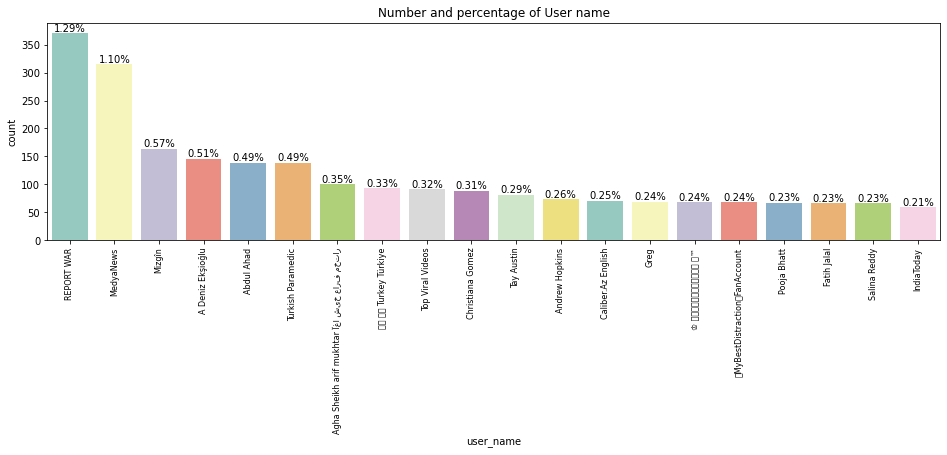

In [15]:
plot_count("user_name", "User name", tweets_df,4)

### Tweet source

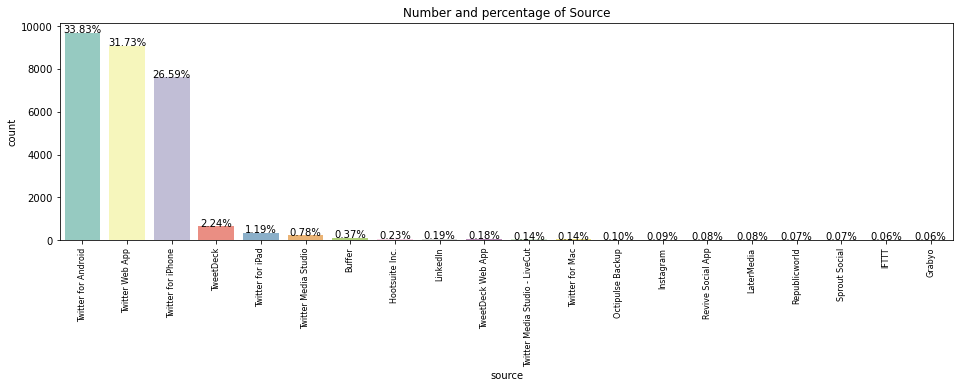

In [16]:
plot_count("source", "Source", tweets_df,4)

In [17]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, mask=None, title=""):
    text = " ".join(t for t in data.dropna())
    stopwords = set(STOPWORDS)
    stopwords.update(["t", "co", "https", "amp", "U", "Comment", "text", "attr", "object"])
    wordcloud = WordCloud(stopwords=stopwords, scale=4, max_font_size=50, max_words=500,mask=mask, background_color="white").generate(text)
    fig = plt.figure(1, figsize=(16,16))
    plt.axis('off')
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()    
    
    

### Text wordcloauds

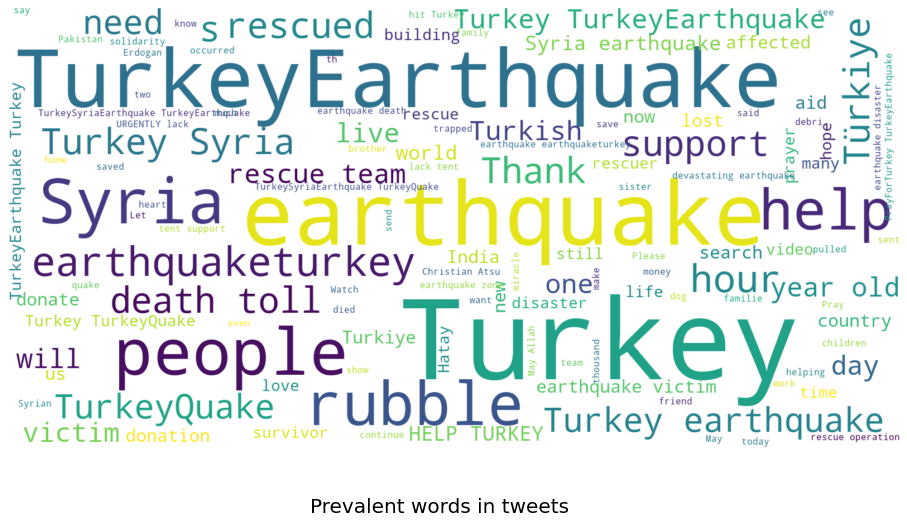

In [18]:
show_wordcloud(tweets_df['text'], title = 'Prevalent words in tweets')

### Extract date and time features

In [19]:
tweets_df['datedt'] = pd.to_datetime(tweets_df['date'])

In [20]:
tweets_df['year'] = tweets_df['datedt'].dt.year
tweets_df['month'] = tweets_df['datedt'].dt.month
tweets_df['day'] = tweets_df['datedt'].dt.day
tweets_df['dayofweek'] = tweets_df['datedt'].dt.dayofweek
tweets_df['hour'] = tweets_df['datedt'].dt.hour
tweets_df['minute'] = tweets_df['datedt'].dt.minute
tweets_df['dayofyear'] = tweets_df['datedt'].dt.dayofyear
tweets_df['date_only'] = tweets_df['datedt'].dt.date

### Time variation

In [21]:
tweets_agg_df = tweets_df.groupby(["date_only"])["text"].count().reset_index()
tweets_agg_df.columns = ["date_only", "count"]

In [22]:
def plot_time_variation(df, x='date_only', y='count', hue=None, size=1, title="", is_log=False):
    sns.set(style="whitegrid")                                                 
    paper_rc = {'lines.linewidth': 3, 'lines.markersize': 20}                  
    sns.set_context("paper", rc = paper_rc)  
    f, ax = plt.subplots(1,1, figsize=(4*size,3*size))
    g = sns.lineplot(x=x, y=y, hue=hue, data=df)
    plt.xticks(rotation=90)
    if hue:
        plt.title(f'{y} grouped by {hue} | {title}')
    else:
        plt.title(f'{y} | {title}')
    if(is_log):
        ax.set(yscale="log")
    ax.grid(color='black', linestyle='dotted', linewidth=0.75)
    plt.show() 

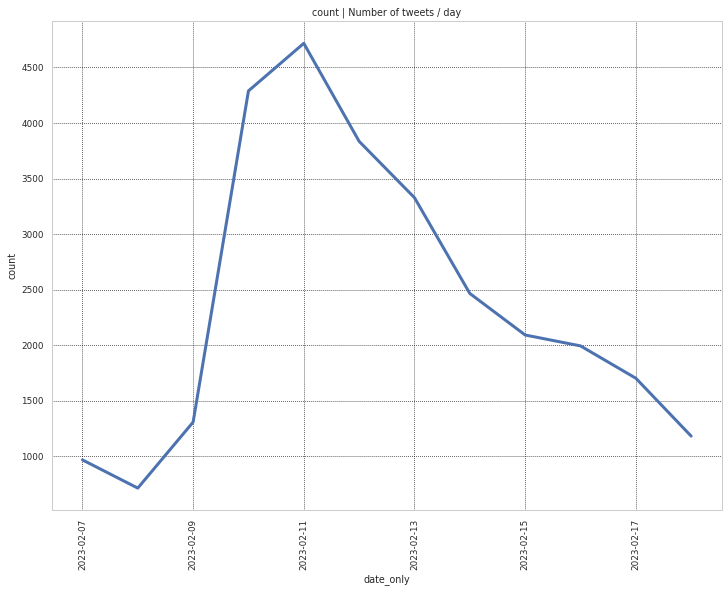

In [23]:
plot_time_variation(tweets_agg_df, x='date_only', title="Number of tweets / day",size=3)

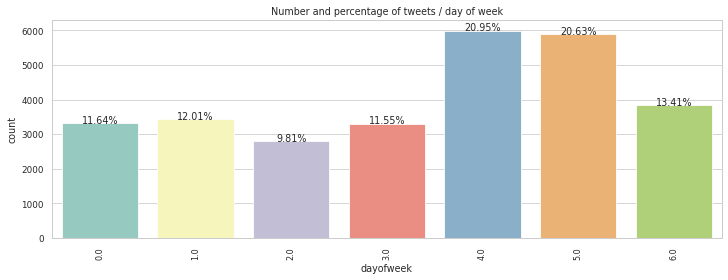

In [24]:
plot_count("dayofweek", "tweets / day of week", tweets_df, size=3, ordered=False)

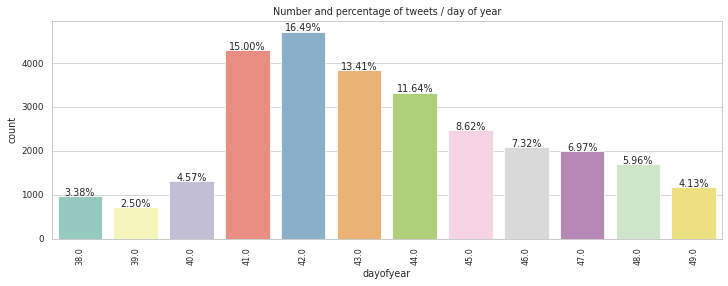

In [25]:
plot_count("dayofyear", "tweets / day of year", tweets_df, size=3, ordered=False)

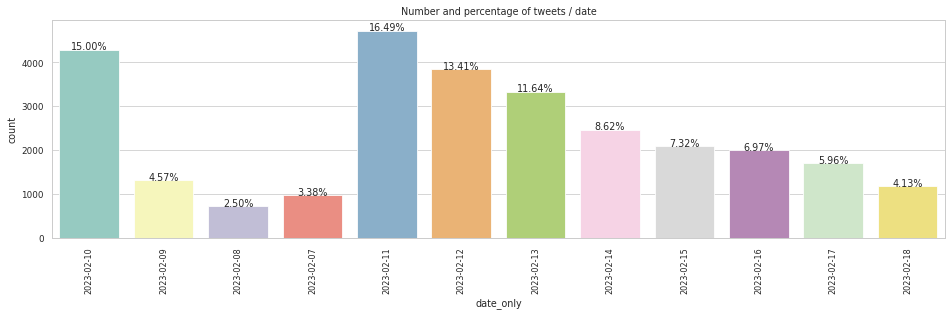

In [26]:
plot_count("date_only", "tweets / date", tweets_df,size=4, ordered=False)

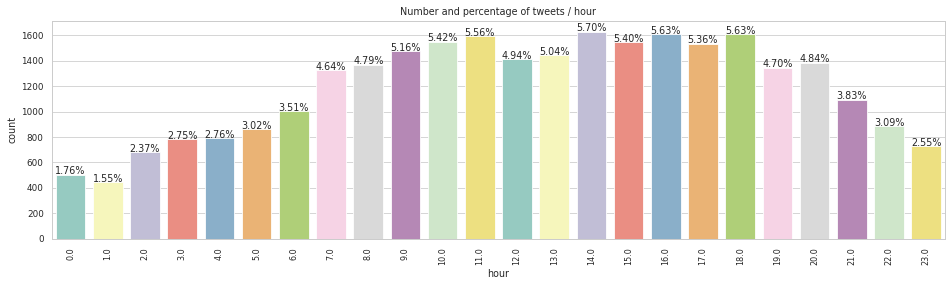

In [27]:
plot_count("hour", "tweets / hour", tweets_df,size=4, ordered=False)

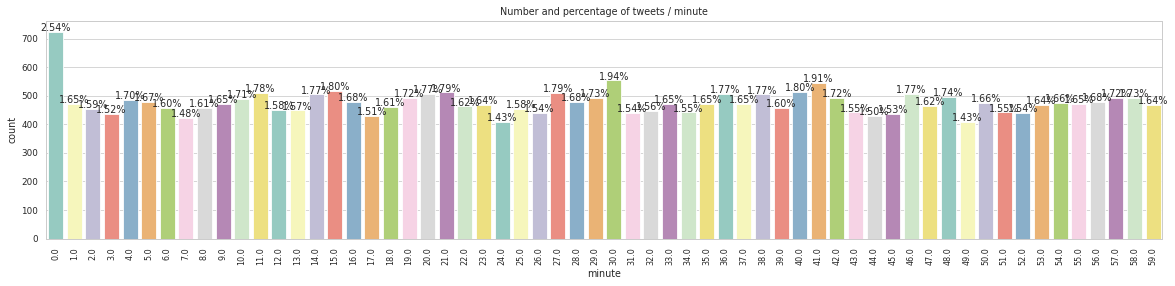

In [28]:
plot_count("minute", "tweets / minute", tweets_df,size=5, ordered=False)

In [29]:
# borrowed from https://www.kaggle.com/pashupatigupta/sentiments-transformer-vader-embedding-bert
sia = SentimentIntensityAnalyzer()
def find_sentiment(post):
    try:
        if sia.polarity_scores(post)["compound"] > 0:
            return "Positive"
        elif sia.polarity_scores(post)["compound"] < 0:
            return "Negative"
        else:
            return "Neutral"  
    except:
        return "Neutral"

In [30]:
def plot_sentiment(df, feature, title):
    counts = df[feature].value_counts()
    percent = counts/sum(counts)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
    
    colors = ["green", "red", "blue"]
    counts.plot(kind='bar', ax=ax1, color=colors)
    percent.plot(kind='bar', ax=ax2, color=colors)
    ax1.set_ylabel(f'Counts : {title} sentiments', size=12)
    ax2.set_ylabel(f'Percentage : {title} sentiments', size=12)
    plt.suptitle(f"Sentiment analysis: {title}")
    plt.tight_layout()
    plt.show()

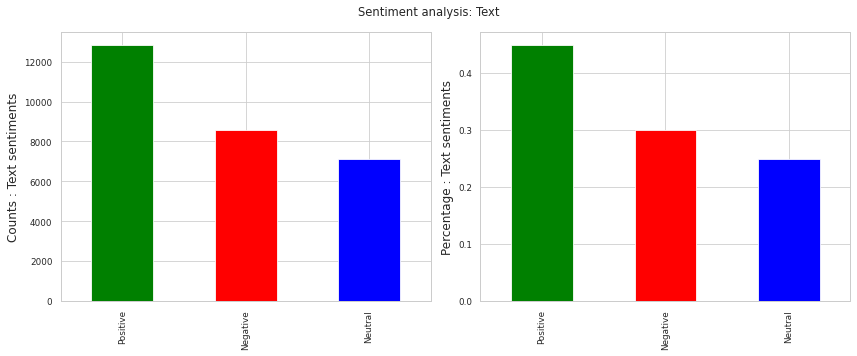

In [31]:
tweets_df['text_sentiment'] = tweets_df['text'].apply(lambda x: find_sentiment(x))
plot_sentiment(tweets_df, 'text_sentiment', 'Text')

Let's see how the sentiment evolved during the last days.

In [32]:
tweets_agg_df = tweets_df.groupby(["date_only", "text_sentiment"])["text"].count().reset_index()
tweets_agg_df.columns = ["date_only", "text_sentiment", "count"]

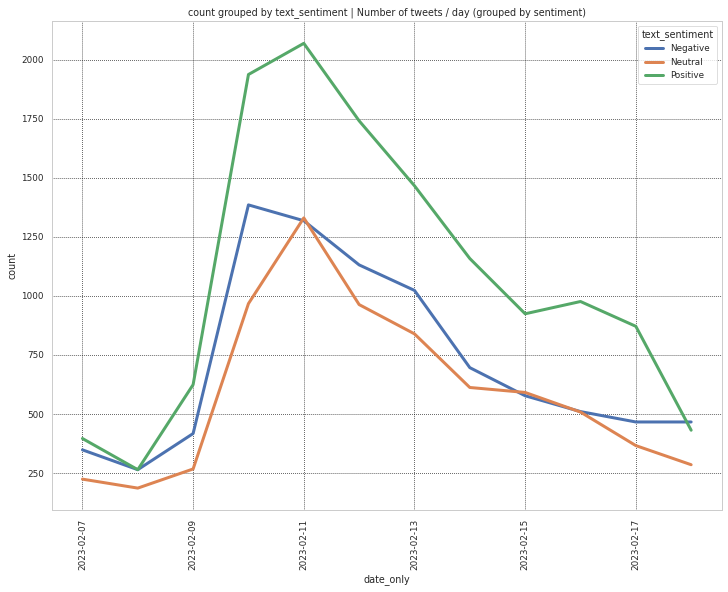

In [33]:
plot_time_variation(tweets_agg_df, x='date_only', hue="text_sentiment", title="Number of tweets / day (grouped by sentiment)",size=3)

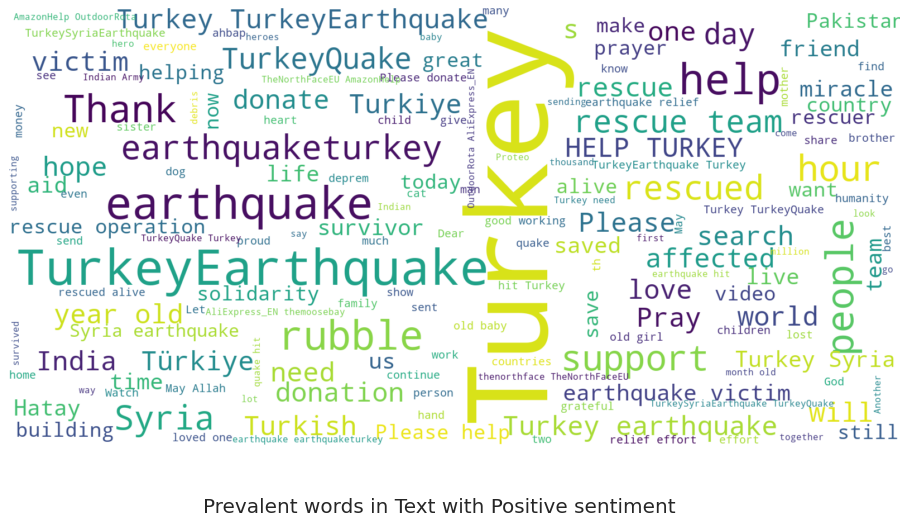

In [34]:
show_wordcloud(tweets_df.loc[tweets_df['text_sentiment']=="Positive", 'text'], title = 'Prevalent words in Text with Positive sentiment', mask=None)

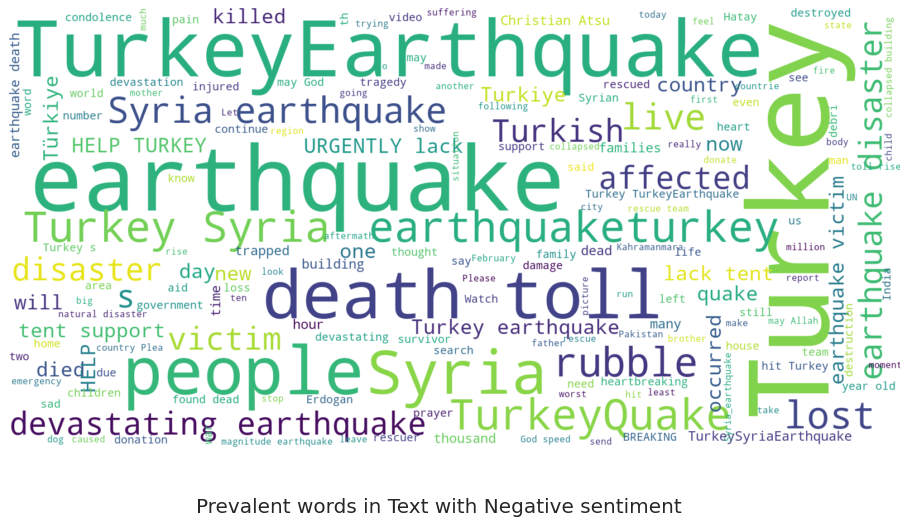

In [35]:
show_wordcloud(tweets_df.loc[tweets_df['text_sentiment']=="Negative", 'text'], title = 'Prevalent words in Text with Negative sentiment', mask=None)

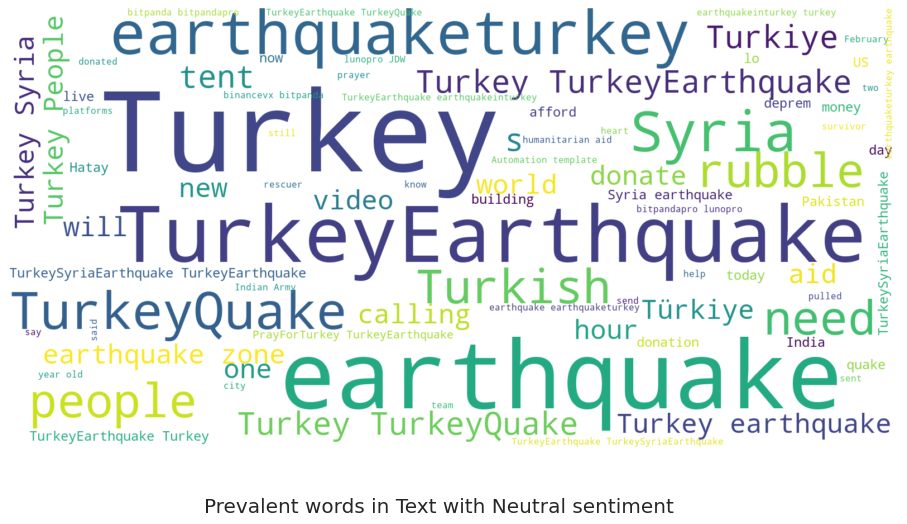

In [36]:
show_wordcloud(tweets_df.loc[tweets_df['text_sentiment']=="Neutral", 'text'], title = 'Prevalent words in Text with Neutral sentiment', mask=None)